In [10]:
from sympy import *
import sympy.physics.mechanics as me
from sympy.utilities.lambdify import lambdify
from sympy.solvers.ode import *
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

me.init_vprinting(use_latex='mathjax')
%matplotlib inline 

In [11]:
t,g,l1,l2,m1,m2 = symbols('t,g,l_1,l_2,m_1,m_2')
theta1,theta2 = me.dynamicsymbols('theta_1 , theta_2 ')
omega1,omega2 = me.dynamicsymbols('theta1 , theta2' , level = 1)
l1 = 100
l2 = 100
m1 = 5
m2=10
g = 9.81

time = (0,80)
t_eval = np.linspace(time[0], time[1],1000)

None

RuntimeError: Requested MovieWriter (ffmpeg) not available

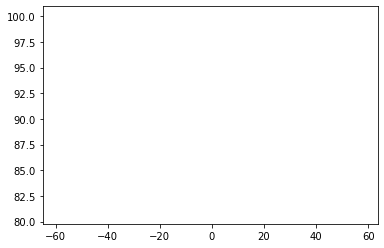

In [12]:
class DynamicAnimation: 
    def __init__(self, data , tspan):
        
        self.theta1 = theta1
        self.theta2 = theta2
        self.omega1 = self.theta1.diff(t) 
        self.omega2 = self.theta2.diff(t)
        self.theta1_0 = 0
        self.theta2_0 = pi/4
        self.omega1_0 = 0
        self.omega2_0 = 0
        
        self.l1 = l1
        self.l2 = l2
        self.m1 = m1
        self.m2 = m2 
        self.g = g
        self.t = t
        self.time = time 
        self.t_eval = t_eval

        self.h1 = self.l1*cos(self.theta1)
        self.h2 =  self.h1 + self.l2*cos(self.theta2)
        
        self.size = self.width , self.height = 1280 , 720
            
    def model(self):        
        self.N = me.ReferenceFrame('N')
        self.A = me.ReferenceFrame('A')
        self.B = me.ReferenceFrame('B')
        self.No = me.Point('No')
        self.A.orient(self.N , 'axis' , (self.theta1, self.N.z))
        self.B.orient(self.A , 'axis' , (self.theta2 , self.A.z))
        self.P1 = me.Point('P1')
        self.P2 = me.Point('P2')
        self.P1.set_pos(self.No , self.l1*self.A.x)
        self.P2.set_pos(self.P1 , self.l2*self.B.x)
        self.v1 = self.P1.set_vel(self.N , self.theta1.diff(t)*self.l1*self.A.x)
        self.v2 = self.P2.set_vel(self.N , (self.theta1.diff(t)*self.l1 + self.theta2.diff(t)*self.l2)*self.B.x)
        self.pP1 = me.Particle('pP1' , self.P1 , self.m1)
        self.pP2 = me.Particle('pP2' , self.P2 , self.m2)
        self.pP1.potential_energy= -self.m1*self.g*self.h1
        self.pP2.potential_energy= -self.m2*self.g*self.h2
        
        self.L = me.Lagrangian(self.N , self.pP1 , self.pP2)     
        self.LM = me.LagrangesMethod(self.L , [self.theta1,self.theta2] , frame = self.N)
        self.EOM = self.LM.form_lagranges_equations()
                    
    def space_state(self):
        
        self.Space_state = self.LM.rhs().subs({sin(self.theta1):self.theta1 , sin(self.theta2):self.theta2})
        return self.Space_state
    
    def solution(self):
        
        self.model()
        self.space_state()
        
        z = ( self.theta1, self.theta2, self.omega1, self.omega2 ) 
        self.lam_f = ( lambdify((self.t,z), list(self.Space_state), 'numpy') )
        
        self.sol = integrate.solve_ivp(self.lam_f, t_span = self.time, y0=(self.theta1_0, self.theta2_0, self.omega1_0, self.omega2_0)
                                       ,t_eval = self.t_eval, dense_output= True) 
        
        self.solution = self.sol.y
        
        self.omega1 = self.solution[2]
        self.omega2 = self.solution[3]
        self.theta1 = self.solution[0]
        self.theta2 = self.solution[1]
        
    def animation(self):
        fig = plt.figure()
        camera = Camera(fig)
        
        for i in range(0,len(self.theta1)):
            x1 =  self.l1*sin(self.theta1[i]) 
            y1 =  self.l1*cos(self.theta1[i])
            x2 =  x1 + self.l2*sin(self.theta2[i])
            y2 =  y1 + self.l2*cos(self.theta2[i])
            
        
            plt.plot(x1,y1)
            camera.snap()
        animation = camera.animate(interval=300, blit=True)
        HTML(animation.to_html5_video())

double_pendulum = DynamicAnimation(theta1 , theta2) 
display(double_pendulum.solution())    
display(double_pendulum.animation())